# Effect of Saint Sampler

This is a presentation document that tests the effects of the Saint Sampler method on the cora dataset of GRACE and GraphMAE.

#### First define training functions for convenience.

Because we can only pass lists of arguments to `parser.parse_args()`, we need to rewrite `build_args()` first.

In [1]:
from main_ssl_gnn_train import train_eval
import argparse

def build_args_for_jupyter():
    parser = argparse.ArgumentParser(description="SSL-GNN-Train Settings")
    parser.add_argument("--model", type=str, default="graphmae")
    parser.add_argument("--seeds", type=int, nargs="+", default=[0])
    parser.add_argument("--dataset", type=str, default="cora")
    parser.add_argument("--device", type=int, default=-1)

    # just for passing arguments, no need to set/change
    parser.add_argument("--num_features", type=int, default=-1)

    # encoder parameters
    parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
    parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
    parser.add_argument("--num_hidden", type=int, default=256, help="number of hidden units")
    parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
    parser.add_argument("--in_drop", type=float, default=.2, help="input feature dropout")
    parser.add_argument("--attn_drop", type=float, default=.1, help="attention dropout")
    parser.add_argument("--norm", type=str, default=None)
    parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
    parser.add_argument("--activation", type=str, default="prelu")

    # parameters of GraphMAE
    parser.add_argument("--mask_rate", type=float, default=0.5)
    parser.add_argument("--drop_edge_rate", type=float, default=0.0)
    parser.add_argument("--replace_rate", type=float, default=0.0)
    parser.add_argument("--encoder", type=str, default="gat")
    parser.add_argument("--decoder", type=str, default="gat")
    parser.add_argument("--loss_fn", type=str, default="sce")
    parser.add_argument("--alpha_l", type=float, default=2, help="`pow`coefficient for `sce` loss")
    parser.add_argument("--concat_hidden", action="store_true", default=False)
    parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")

    # parameters of Grace
    parser.add_argument("--num_proj_hidden", type=int, default=1, help="h->z linear in grace")
    parser.add_argument("--drop_edge_rate_1", type=float, default=0.5)
    parser.add_argument("--drop_edge_rate_2", type=float, default=0.5)
    parser.add_argument("--drop_feature_rate_1", type=float, default=0.5)
    parser.add_argument("--drop_feature_rate_2", type=float, default=0.5)
    parser.add_argument("--tau", type=float, default=0.5)

    # pretraining settings
    parser.add_argument("--optimizer", type=str, default="adam")
    parser.add_argument("--scheduler", action="store_true", default=False)
    parser.add_argument("--warmup_steps", type=int, default=-1)
    parser.add_argument("--max_epoch", type=int, default=200, help="number of training epochs")
    parser.add_argument("--lr", type=float, default=0.005, help="learning rate")

    # eval settings
    parser.add_argument("--weight_decay", type=float, default=5e-4, help="weight decay")
    parser.add_argument("--max_epoch_f", type=int, default=30)
    parser.add_argument("--lr_f", type=float, default=0.001, help="learning rate for evaluation")
    parser.add_argument("--weight_decay_f", type=float, default=0.0, help="weight decay for evaluation")

    # graph sampler settings
    parser.add_argument("--use_sampler", action="store_true", default=False)
    parser.add_argument("--budget", type=int, default=500, help="number of nodes sampled per batch with SaintSampler")
    parser.add_argument("--num_iters", type=int, default=0, help="iters to train (0: max_epoch*total_nodes_num/budget)")

    # other settings
    parser.add_argument("--load_model", action="store_true")
    parser.add_argument("--load_model_path", type=str, default="")
    parser.add_argument("--save_model", action="store_true")
    parser.add_argument("--save_model_path", type=str, default="")
    parser.add_argument("--use_cfg", action="store_true")
    parser.add_argument("--use_cfg_path", type=str, default="")
    parser.add_argument("--no_verbose", action="store_true", help="do not print process info")
    parser.add_argument("--eval_steps", type=int, default="200", help="epochs per evaluation during pretraining")
    parser.add_argument("--eval_nums", type=int, default="0", help="if set to non-zero, omit --eval_steps")
    args = parser.parse_args(args=[])
    return args

Then define running functions: set the arguments packages and run.

In [2]:
from utils.utils import process_args

def run_cora_test(budget_list,method_name):
 acc_list=[]
 args = build_args_for_jupyter()
 for budget in budget_list:
  args = build_args_for_jupyter()
  args.use_cfg=True
  args.no_verbose=True
  args.model=method_name
  args = process_args(args)
  args.dataset='cora'
  args.use_sampler=True
  args.num_iters=0
  args.device=0
  args.max_epoch=500
  print(f"---- Sampler budget : {budget} ----")
  args.budget=budget
  acc_list.append(train_eval(args))

 args.num_iters=0
 args.max_epoch=500
 args.use_sampler=False
 print(f"---- Sampler budget : full graph ----")
 acc_list.append(train_eval(args))
 print(acc_list)
 return acc_list

Draw functions:

In [8]:
import matplotlib.pyplot as plt

def draw(result,label):
    x=budget_list
    y1 = result[:-1]  # Sample data.
    plt.figure(figsize=(10, 5), layout='constrained')
    plt.plot(x, y1, label=label)  # Plot some data on the (implicit) axes.
    plt.axhline(result[-1],label='GraphMAE (full graph)',color='r')
    plt.xlabel('budget')
    plt.ylabel('acc')
    plt.title("Effect of Saint Sampler")
    plt.legend()

## Then train
For fairness in comparison, the number of training sessions is set to the default value: $ N(graph_{full})\times epochs/ budget$.
Because of time limit, here we set pretrain max_epoch to 500.

In [4]:
from tqdm.notebook import tqdm
budget_list=[200,500,1000,1500,2000,2708]
result_graphmae=run_cora_test(budget_list,'graphmae')

---- Sampler budget : 200 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 6769: train_loss: 0.5938: 100%|██████████| 6770/6770 [03:11<00:00, 35.32it/s]


# final-dev-acc: 0.6940±0.0000# early-stopping-dev-acc: 0.6940±0.0000
# final-test-acc: 0.6980±0.0000# early-stopping-test-acc: 0.6980±0.0000
---- Sampler budget : 500 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 2707: train_loss: 0.5225: 100%|██████████| 2708/2708 [01:18<00:00, 34.51it/s]


# final-dev-acc: 0.7080±0.0000# early-stopping-dev-acc: 0.7100±0.0000
# final-test-acc: 0.7550±0.0000# early-stopping-test-acc: 0.7530±0.0000
---- Sampler budget : 1000 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 1353: train_loss: 0.4729: 100%|██████████| 1354/1354 [00:40<00:00, 33.16it/s]


# final-dev-acc: 0.7600±0.0000# early-stopping-dev-acc: 0.7600±0.0000
# final-test-acc: 0.8090±0.0000# early-stopping-test-acc: 0.8090±0.0000
---- Sampler budget : 1500 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 901: train_loss: 0.4553: 100%|██████████| 902/902 [00:28<00:00, 32.16it/s]


# final-dev-acc: 0.7720±0.0000# early-stopping-dev-acc: 0.7720±0.0000
# final-test-acc: 0.8150±0.0000# early-stopping-test-acc: 0.8150±0.0000
---- Sampler budget : 2000 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 676: train_loss: 0.4478: 100%|██████████| 677/677 [00:21<00:00, 31.01it/s]


# final-dev-acc: 0.7900±0.0000# early-stopping-dev-acc: 0.7920±0.0000
# final-test-acc: 0.8280±0.0000# early-stopping-test-acc: 0.8290±0.0000
---- Sampler budget : 2708 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 499: train_loss: 0.4436: 100%|██████████| 500/500 [00:16<00:00, 30.23it/s]


# final-dev-acc: 0.7900±0.0000# early-stopping-dev-acc: 0.7900±0.0000
# final-test-acc: 0.8260±0.0000# early-stopping-test-acc: 0.8260±0.0000
---- Sampler budget : full graph ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 499: train_loss: 0.4256: 100%|██████████| 500/500 [00:16<00:00, 31.21it/s]


# final-dev-acc: 0.7980±0.0000# early-stopping-dev-acc: 0.7980±0.0000
# final-test-acc: 0.8320±0.0000# early-stopping-test-acc: 0.8320±0.0000
[0.698, 0.755, 0.809, 0.815, 0.828, 0.826, 0.832]


[0.698, 0.755, 0.809, 0.815, 0.828, 0.826, 0.832]


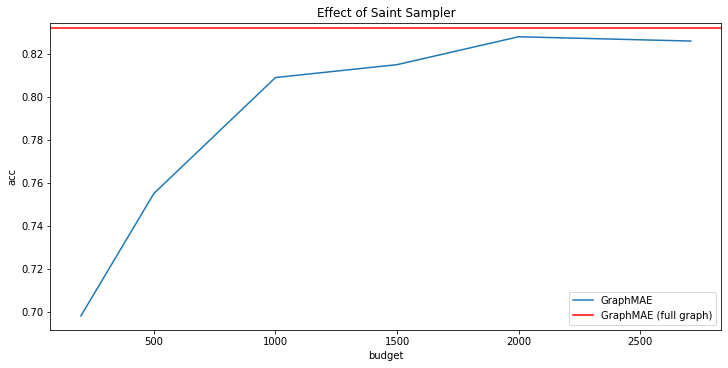

In [9]:
print(result_graphmae)
draw(result_graphmae,'GraphMAE')

In [11]:
from tqdm.notebook import tqdm
result_grace=run_cora_test(budget_list,'grace')

---- Sampler budget : 200 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.




  0%|          | 0/6770 [00:00<?, ?it/s]

# Epochs 0: train_loss: 5.8936:   0%|          | 0/6770 [00:00<?, ?it/s]

# Epochs 1: train_loss: 5.9233:   0%|          | 0/6770 [00:00<?, ?it/s]

# Epochs 1: train_loss: 5.9233:   0%|          | 2/6770 [00:00<05:52, 19.19it/s]

# Epochs 2: train_loss: 5.9194:   0%|          | 2/6770 [00:00<05:52, 19.19it/s]

# Epochs 3: train_loss: 5.8649:   0%|          | 2/6770 [00:00<05:52, 19.19it/s]

# Epochs 4: train_loss: 5.8469:   0%|          | 2/6770 [00:00<05:52, 19.19it/s]

# Epochs 4: train_loss: 5.8469:   0%|          | 5/6770 [00:00<04:50, 23.26it/s]

# Epochs 5: train_loss: 5.8449:   0%|          | 5/6770 [00:00<04:50, 23.26it/s]

# Epochs 6: train_loss: 5.7993:   0%|          | 5/6770 [00:00<04:50, 23.26it/s]

# Epochs 7: train_loss: 5.8439:   0%|          | 5/6770 [00:00<04:50, 23.26it/s]

# Epochs 7: train_loss: 5.8439:   0%|          | 8/6770 [00:00<04:31, 24.90it/s]

# Epochs 8: train_loss: 5.8747:   0%|          | 8/6770 [00:00<04:31, 

# final-dev-acc: 0.7180±0.0000# early-stopping-dev-acc: 0.7240±0.0000
# final-test-acc: 0.7430±0.0000# early-stopping-test-acc: 0.7400±0.0000
---- Sampler budget : 500 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 2707: train_loss: 6.2198: 100%|██████████| 2708/2708 [01:38<00:00, 27.55it/s]


# final-dev-acc: 0.7420±0.0000# early-stopping-dev-acc: 0.7420±0.0000
# final-test-acc: 0.7850±0.0000# early-stopping-test-acc: 0.7850±0.0000
---- Sampler budget : 1000 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 1353: train_loss: 6.5310: 100%|██████████| 1354/1354 [00:49<00:00, 27.50it/s]


# final-dev-acc: 0.7540±0.0000# early-stopping-dev-acc: 0.7560±0.0000
# final-test-acc: 0.7770±0.0000# early-stopping-test-acc: 0.7770±0.0000
---- Sampler budget : 1500 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 901: train_loss: 6.7447: 100%|██████████| 902/902 [00:35<00:00, 25.59it/s]


# final-dev-acc: 0.7420±0.0000# early-stopping-dev-acc: 0.7480±0.0000
# final-test-acc: 0.7730±0.0000# early-stopping-test-acc: 0.7670±0.0000
---- Sampler budget : 2000 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 676: train_loss: 6.9699: 100%|██████████| 677/677 [00:29<00:00, 22.84it/s]


# final-dev-acc: 0.7440±0.0000# early-stopping-dev-acc: 0.7440±0.0000
# final-test-acc: 0.7700±0.0000# early-stopping-test-acc: 0.7700±0.0000
---- Sampler budget : 2708 ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 499: train_loss: 7.0883: 100%|██████████| 500/500 [00:24<00:00, 20.17it/s]


# final-dev-acc: 0.7600±0.0000# early-stopping-dev-acc: 0.7720±0.0000
# final-test-acc: 0.7690±0.0000# early-stopping-test-acc: 0.7680±0.0000
---- Sampler budget : full graph ----
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Epochs 499: train_loss: 7.5408: 100%|██████████| 500/500 [00:36<00:00, 13.60it/s]


# final-dev-acc: 0.7360±0.0000# early-stopping-dev-acc: 0.7380±0.0000
# final-test-acc: 0.7750±0.0000# early-stopping-test-acc: 0.7730±0.0000
[0.743, 0.785, 0.777, 0.773, 0.77, 0.769, 0.775]


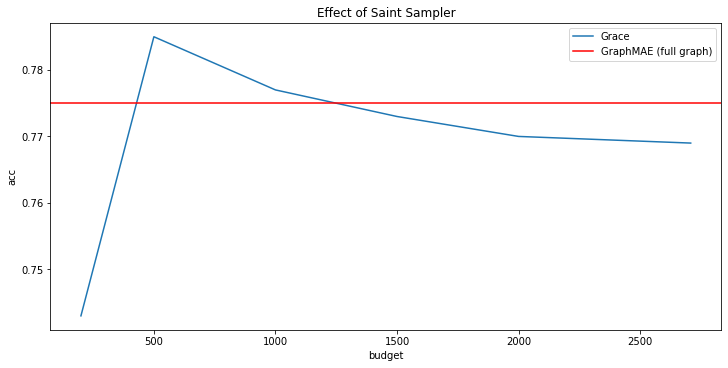

In [12]:
draw(result_grace,'Grace')